In [1]:
from uuid import uuid4

from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.types import Command, interrupt

In [2]:
import sys

sys.path.append("../../")

load_dotenv("../.env")

from api.core.config import settings

print(settings.LLM_HOST)

http://localhost:8090


In [3]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return f"I looked up: {query}. Result: It's sunny in San Francisco, but you better look out if you're a Gemini 😈."


tools = [search]
tool_node = ToolNode(tools)

from pydantic import BaseModel


class AskHuman(BaseModel):
    """Ask the human a question"""

    question: str

In [4]:
from langchain_deepseek import ChatDeepSeek

llm = ChatDeepSeek(
    api_base=f"http://localhost:8090/v1",
    api_key="sk-no-key-required",
    model="deepseek-coder:latest",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

llm = llm.bind_tools(tools + [AskHuman])

In [5]:
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # If tool call is asking Human, we return that node
    # You could also add logic here to let some system know that there's something that requires Human input
    # For example, send a slack message, etc
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "action"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = llm.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# We define a fake node to ask the human
def ask_human(state):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    print(state["messages"][-1].tool_calls[0])
    ask = AskHuman.model_validate(state["messages"][-1].tool_calls[0]["args"])
    location = interrupt(ask.question)
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": location}]
    return {"messages": tool_message}


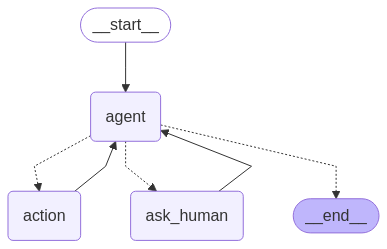

In [6]:
workflow = StateGraph(MessagesState)
# Define the three nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("action", "agent")
workflow.add_edge("ask_human", "agent")


# Set up memory
memory = MemorySaver()

# Add
graph = workflow.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Input
initial_input = {
    "messages": [
        (
            "user",
            "Ask the user where they are, then look up the weather there.",
        )
    ]
}

# Thread
config = {"configurable": {"thread_id": uuid4()}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, config, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================ Human Message =================================

Ask the user where they are, then look up the weather there.
None
================================== Ai Message ==================================
Tool Calls:
  AskHuman (j0yzlF2L3kWOKrst0e7SIXRrQGXAhrt7)
 Call ID: j0yzlF2L3kWOKrst0e7SIXRrQGXAhrt7
  Args:
    question: Where are you?
None
{'name': 'AskHuman', 'args': {'question': 'Where are you?'}, 'id': 'j0yzlF2L3kWOKrst0e7SIXRrQGXAhrt7', 'type': 'tool_call'}


In [10]:
for event in graph.stream(
    Command(resume="san francisco"), config, stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  AskHuman (j0yzlF2L3kWOKrst0e7SIXRrQGXAhrt7)
 Call ID: j0yzlF2L3kWOKrst0e7SIXRrQGXAhrt7
  Args:
    question: Where are you?
{'name': 'AskHuman', 'args': {'question': 'Where are you?'}, 'id': 'j0yzlF2L3kWOKrst0e7SIXRrQGXAhrt7', 'type': 'tool_call'}
================================= Tool Message =================================

san francisco
================================== Ai Message ==================================
Tool Calls:
  search (kH5BXkDaM8kFeNklWbVwVi1B3azUQJ8G)
 Call ID: kH5BXkDaM8kFeNklWbVwVi1B3azUQJ8G
  Args:
    query: weather in San Francisco today
================================= Tool Message =================================
Name: search

I looked up: weather in San Francisco today. Result: It's sunny in San Francisco, but you better look out if you're a Gemini 😈.
================================== Ai Message ==================================



It seems like you're pro